# Program in Computational Data Science

##  A program by IISc

### Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

## Data Wrangling

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

## Load the data

In [3]:
# YOUR CODE HERE
data = pd.read_csv("Online_Retail_Train.csv")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom


**Finding unique values**

In [4]:
print('A total of '+ str(data.InvoiceNo.nunique()) +' unique invoices were generated.')
print('We have '+ str(data.StockCode.nunique()) +' unique products sold online.')
print('We have '+ str(data.CustomerID.nunique()) +' unique Customers in our dataset.')
print('We have customers spread across '+ str(data.Country.nunique()) +' countries. ')

A total of 25610 unique invoices were generated.
We have 4062 unique products sold online.
We have 4367 unique Customers in our dataset.
We have customers spread across 38 countries. 


In [5]:
# looking at the overall picture
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514813 entries, 0 to 514812
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    514813 non-null  object 
 1   StockCode    514813 non-null  object 
 2   Description  513428 non-null  object 
 3   Quantity     514813 non-null  int64  
 4   InvoiceDate  514813 non-null  object 
 5   UnitPrice    514813 non-null  float64
 6   CustomerID   386550 non-null  float64
 7   Country      514813 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 31.4+ MB


## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://kanoki.org/2020/04/23/how-to-remove-outliers-in-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [6]:
# YOUR CODE HERE
def remove_duplicates(df):
    """
    Removes duplicated rows from a pandas DataFrame
    
    Parameters:
    df (pandas DataFrame): The DataFrame to be checked
    
    Returns:
    pandas DataFrame: A copy of the input DataFrame with duplicated rows removed
    """
    # Check for duplicated rows
    duplicates = df.duplicated()
    
    # Remove duplicated rows
    non_duplicates = df[~duplicates]
    
    # Return the non-duplicated DataFrame
    return non_duplicates

In [7]:
# Call the remove_duplicates function
non_duplicates = remove_duplicates(data)

# Print the original and non-duplicated DataFrames
print('Original DataFrame:\n', data.shape)
print('Non_duplicated DataFrame:\n', non_duplicates.shape)

Original DataFrame:
 (514813, 8)
Non_duplicated DataFrame:
 (510059, 8)


In [8]:
def drop_nulls(df):
    """
    Counts the number of null values in a pandas DataFrame and drops all rows with null values
    
    Parameters:
    df (pandas DataFrame): The DataFrame to be checked
    
    Returns:
    pandas DataFrame: A copy of the input DataFrame with null rows removed
    """
    # Count the number of null values in each column
    null_counts = df.isnull().sum().sort_values(ascending=False)
    
    # Print the null counts for each column
    print('Null counts:\n', null_counts)
    
    # Drop rows with null values
    non_nulls = df.dropna()
    
    # Return the non-null DataFrame
    return non_nulls

In [9]:
# Call the drop_nulls function
non_nulls = drop_nulls(non_duplicates)

# Print the original and non-null DataFrames
print('Original DataFrame:\n', non_duplicates.shape)
print('Non-null DataFrame:\n', non_nulls.shape)

Null counts:
 CustomerID     128222
Description      1385
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64
Original DataFrame:
 (510059, 8)
Non-null DataFrame:
 (381837, 8)


In [10]:
def drop_cancelled_orders(df):
    """
    Counts the number of cancelled orders in a pandas DataFrame and drops all cancelled orders
    
    Parameters:
    df (pandas DataFrame): The DataFrame to be checked
    
    Returns:
    pandas DataFrame: A copy of the input DataFrame with cancelled orders removed
    """
    # Create a new DataFrame with only cancelled orders
    cancelled_orders = df[df['InvoiceNo'].str.startswith('C', na=False)]
    
    # Count the number of cancelled orders
    num_cancelled = len(cancelled_orders)
    
    # Drop cancelled orders from the original DataFrame
    non_cancelled = df[~df['InvoiceNo'].str.startswith('C')]
    
    # Print the number of cancelled orders and return the non-cancelled DataFrame
    print('Number of cancelled orders:', num_cancelled)
    return non_cancelled

In [11]:
# Call the drop_cancelled_orders function
non_cancelled = drop_cancelled_orders(non_nulls)

# Print the original and non-cancelled DataFrames
print('Original DataFrame:\n', non_nulls.shape)
print('Non-cancelled DataFrame:\n', non_cancelled.shape)

Number of cancelled orders: 8403
Original DataFrame:
 (381837, 8)
Non-cancelled DataFrame:
 (373434, 8)


In [12]:
# top 10 stock ids that sold the most
data.StockCode.value_counts().head(10)

85123A    2190
22423     2104
85099B    2049
47566     1652
20725     1577
84879     1416
22720     1409
22197     1393
21212     1318
20727     1288
Name: StockCode, dtype: int64

In [13]:
def filter_irrelevant_transactions(df, codes_to_remove):
    """
    Filters out irrelevant transactions from a pandas DataFrame based on a list of StockCodes to remove
    
    Parameters:
    df (pandas DataFrame): The DataFrame to be filtered
    codes_to_remove (list): A list of StockCodes to remove from the DataFrame
    
    Returns:
    pandas DataFrame: A copy of the input DataFrame with irrelevant transactions removed
    """
    # Filter out the irrelevant transactions
    filtered_df = df[~df['StockCode'].isin(codes_to_remove)]
    
    # Count the number of irrelevant codes in the original data
    count_irrelevant = len(df) - len(filtered_df)
    print(f"There are {count_irrelevant} irrelevant codes in the data.")
    
    # Return the filtered DataFrame
    return filtered_df

In [14]:
# Define the irrelevant codes
irrelevant_codes = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']

# Call the filter_irrelevant_transactions function
filtered = filter_irrelevant_transactions(non_cancelled, irrelevant_codes)

# Print the original and filtered DataFrames
print('Original DataFrame:\n', non_cancelled.shape)
print('Filtered DataFrame:\n', filtered.shape)

There are 1465 irrelevant codes in the data.
Original DataFrame:
 (373434, 8)
Filtered DataFrame:
 (371969, 8)


In [15]:
# checking the distribution of unit price
data.UnitPrice.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    514813.000000
mean          4.586406
std          95.660226
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
90%           7.950000
95%           9.950000
99%          18.000000
max       38970.000000
Name: UnitPrice, dtype: float64

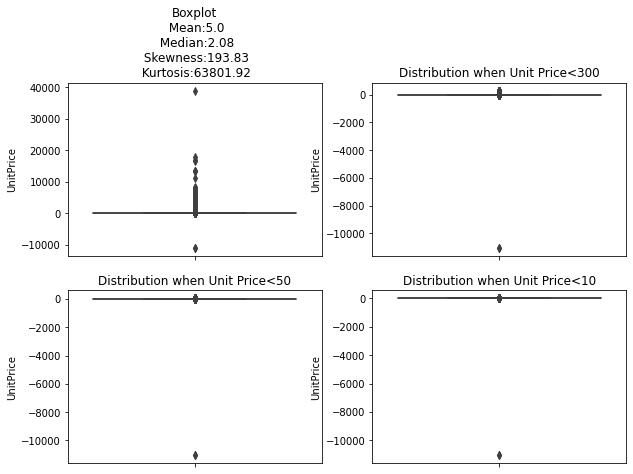

In [16]:
# Looking the distribution of column Unit Price
plt.figure(figsize=(10,7))

skewness = round(data.UnitPrice.skew(),2)
kurtosis = round(data.UnitPrice.kurtosis(),2)
mean = round(np.mean(data.UnitPrice),0)
median = np.median(data.UnitPrice)

plt.subplot(2,2,1)
sns.boxplot(y=data.UnitPrice)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.subplot(2,2,2)
sns.boxplot(y=data[data.UnitPrice<300]['UnitPrice'])
plt.title('Distribution when Unit Price<300')

plt.subplot(2,2,3)
sns.boxplot(y=data[data.UnitPrice<50]['UnitPrice'])
plt.title('Distribution when Unit Price<50')

plt.subplot(2,2,4)
sns.boxplot(y=data[data.UnitPrice<10]['UnitPrice'])
plt.title('Distribution when Unit Price<10')

plt.show()


In [17]:
# checking the distribution of Quantity
data.Quantity.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    514813.000000
mean          9.552498
std         223.529242
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
90%          24.000000
95%          28.000000
99%         100.000000
max       80995.000000
Name: Quantity, dtype: float64

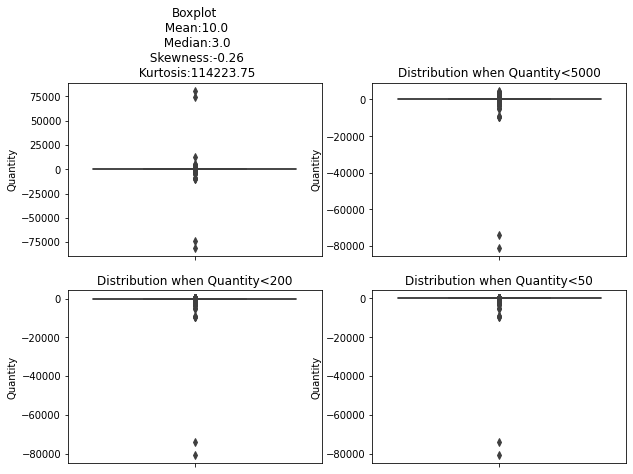

In [18]:
# Looking the distribution of column Quantity
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
sns.boxplot(y=data.Quantity)
skewness = round(data.Quantity.skew(),2)
kurtosis = round(data.Quantity.kurtosis(),2)
mean = round(np.mean(data.Quantity),0)
median = np.median(data.Quantity)
plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean,median,skewness,kurtosis))

plt.subplot(2,2,2)
sns.boxplot(y=data[data.Quantity<5000]['Quantity'])
plt.title('Distribution when Quantity<5000')

plt.subplot(2,2,3)
sns.boxplot(y=data[data.Quantity<200]['Quantity'])
plt.title('Distribution when Quantity<200')

plt.subplot(2,2,4)
sns.boxplot(y=data[data.Quantity<50]['Quantity'])
plt.title('Distribution when Quantity<50')

plt.show()


In [19]:
def handle_outliers(df):
    """
    Handles outliers in a pandas DataFrame by calculating z-scores for UnitPrice and Quantity,
    identifying outliers based on a threshold of 3 standard deviations, and removing them from the DataFrame
    
    Parameters:
    df (pandas DataFrame): The DataFrame to be processed
    
    Returns:
    pandas DataFrame: A copy of the input DataFrame with outliers removed
    """
    # Calculate z-scores for UnitPrice and Quantity
    z_scores = np.abs((df[['UnitPrice', 'Quantity']] - df[['UnitPrice', 'Quantity']].mean()) / df[['UnitPrice', 'Quantity']].std())
    
    # Identify outliers by applying a threshold of 3 standard deviations
    outliers = df[(z_scores > 3).any(axis=1)]
    
    # Handle outliers by removing them from the DataFrame
    df = df[(z_scores <= 3).all(axis=1)]
    
    # Print the number of outliers and the shape of the DataFrame after outlier removal
    print(f"Identified {len(outliers)} outliers. DataFrame shape after outlier removal: {df.shape}")
    
    # Return the DataFrame with outliers removed
    return df

In [20]:
# Call the handle_outliers function
processed = handle_outliers(filtered)

# Print the original and processed DataFrames
print('Original DataFrame:\n', filtered.shape)
print('Processed DataFrame:\n', processed.shape)

Identified 2524 outliers. DataFrame shape after outlier removal: (369445, 8)
Original DataFrame:
 (371969, 8)
Processed DataFrame:
 (369445, 8)


In [21]:
# checking the number of unique item list
processed.Description.nunique()

3822

In [22]:
# top 10 item sold
processed.Description.value_counts().head(10)

WHITE HANGING HEART T-LIGHT HOLDER    1904
REGENCY CAKESTAND 3 TIER              1629
JUMBO BAG RED RETROSPOT               1530
PARTY BUNTING                         1329
ASSORTED COLOUR BIRD ORNAMENT         1312
LUNCH BAG RED RETROSPOT               1252
SET OF 3 CAKE TINS PANTRY DESIGN      1100
LUNCH BAG  BLACK SKULL.               1027
PACK OF 72 RETROSPOT CAKE CASES        996
SPOTTY BUNTING                         962
Name: Description, dtype: int64

In [23]:
# there are cases where the descriptions contains some code/name which are not directly refers to sales
# checking the data where description = ? and it is noted that customerid is NaN and unit price is 0
processed[processed['Description'].str.startswith('?')==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [24]:
# checking the data where description = * and it is noted that customerid is NaN
processed[processed['Description'].str.startswith('*')==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [25]:
# Description have actual entries in uppercase words and those who don't have are some of the noises in the dataset
processed[processed['Description'].str.islower()==True]['Description'].value_counts()

Series([], Name: Description, dtype: int64)

In [26]:
# Description have actual entries in uppercase words and those who don't have are some of the noises in the dataset
processed[processed['Description'].str.istitle()==True]['Description'].value_counts()

Next Day Carriage        78
High Resolution Image     2
Name: Description, dtype: int64

In [27]:
processed[processed['Description'].str.istitle()==True]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
8124,562148,23444,Next Day Carriage,1,2011-08-03 10:49:00,15.0,13695.0,United Kingdom
18416,574282,23444,Next Day Carriage,1,2011-11-03 14:52:00,15.0,15612.0,United Kingdom
26477,568680,23444,Next Day Carriage,1,2011-09-28 14:10:00,15.0,18265.0,United Kingdom
29837,576148,23444,Next Day Carriage,1,2011-11-14 10:50:00,15.0,15671.0,United Kingdom
35953,581221,23444,Next Day Carriage,1,2011-12-08 09:40:00,15.0,17856.0,United Kingdom
...,...,...,...,...,...,...,...,...
483249,579185,23444,Next Day Carriage,1,2011-11-28 15:28:00,15.0,13188.0,United Kingdom
485311,558908,23444,Next Day Carriage,1,2011-07-05 09:06:00,15.0,13338.0,United Kingdom
485657,559206,23444,Next Day Carriage,1,2011-07-07 11:12:00,15.0,18073.0,United Kingdom
492348,561115,23444,Next Day Carriage,1,2011-07-25 12:12:00,15.0,17675.0,United Kingdom


In [28]:
# removing all the above listed noises
processed = processed[processed['Description'].str.istitle()!=True]
processed.shape

(369365, 8)

In [29]:
#removes any leading or trailing white space characters from the Description column of df.
data['Description'] = data['Description'].str.strip()

In [30]:
def convert_date_column(df, column_name):
    # check the data type of the specified column
    print('Before: ', df[column_name].dtypes)

    # convert the specified column to datetime64[ns]
    df[column_name] = pd.to_datetime(df[column_name])

    # check the data type of the specified column after conversion
    print('After: ', df[column_name].dtypes)

    # print the minimum and maximum dates for the specified column
    print('The minimum date is:', df[column_name].min())
    print('The maximum date is:', df[column_name].max())

    return df

In [31]:
processed = convert_date_column(processed, 'InvoiceDate')
processed

Before:  object
After:  datetime64[ns]
The minimum date is: 2010-12-01 08:26:00
The maximum date is: 2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium
...,...,...,...,...,...,...,...,...
514803,551891,21402,RED EGG SPOON,24,2011-05-05 09:53:00,0.12,17429.0,United Kingdom
514806,548156,22652,TRAVEL SEWING KIT,2,2011-03-29 13:22:00,1.65,14871.0,United Kingdom
514808,545682,22975,SPACEBOY CHILDRENS EGG CUP,3,2011-03-06 11:39:00,1.25,14701.0,United Kingdom
514809,559691,22089,PAPER BUNTING VINTAGE PAISLEY,12,2011-07-11 15:52:00,2.95,13089.0,United Kingdom


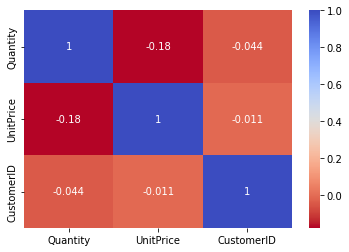

In [ ]:
sns.heatmap(processed.corr(), 
        xticklabels=processed.corr().columns,
        yticklabels=processed.corr().columns,annot=True, cmap='coolwarm_r')
plt.show()

The variables are not corelated with each other.

## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [32]:
def add_total_price_column(df):
    # create a new column called TotalPrice that represents the total amount spent by each customer
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    # return the updated DataFrame
    return df

In [33]:
processed = add_total_price_column(processed)
processed.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,17.00
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,10.08
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,2.52
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,15.60
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,18.00


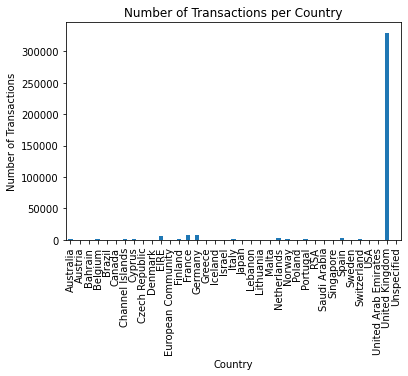

In [34]:
# YOUR CODE HERE
# group the transactions by country and count the number of transactions in each group
transaction_counts = processed.groupby('Country')['InvoiceNo'].count()

# create a bar plot of the number of transactions per country
transaction_counts.plot(kind='bar')

# set the title and axis labels
plt.title('Number of Transactions per Country')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')

# display the plot
plt.show()

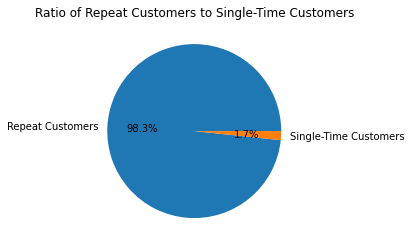

In [35]:
# group the transactions by customer and count the number of transactions in each group
transaction_counts = processed.groupby('CustomerID')['InvoiceNo'].count()

# calculate the number of customers who made more than one transaction and the number of customers who made only one transaction
num_repeat_customers = (transaction_counts > 1).sum()
num_single_customers = (transaction_counts == 1).sum()

# calculate the ratio of repeat purchasers to single-time purchasers
#repeat_to_single_ratio = num_repeat_customers / num_single_customers

# create a pie chart of the ratio of repeat purchasers to single-time purchasers
plt.pie([num_repeat_customers, num_single_customers], labels=['Repeat Customers', 'Single-Time Customers'], autopct='%1.1f%%')

# set the title
plt.title('Ratio of Repeat Customers to Single-Time Customers')

# display the plot
plt.show()

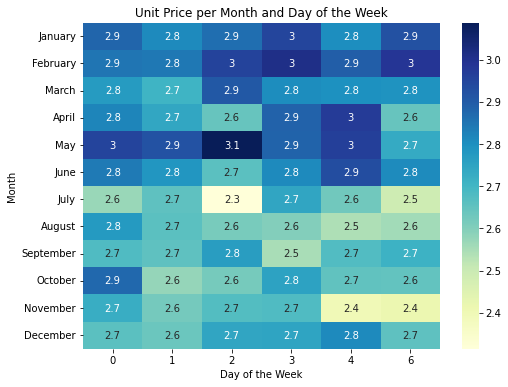

In [36]:
# convert the InvoiceDate column to a datetime datatype
#df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
import calendar
# create columns for month and day of the week
processed['Month'] = processed['InvoiceDate'].dt.month
processed['DayOfWeek'] = processed['InvoiceDate'].dt.dayofweek

# create a pivot table with the month name as rows, day of the week as columns, and the mean unit price as values
pivot_table = pd.pivot_table(processed, values='UnitPrice', index=processed['InvoiceDate'].dt.month_name(), columns='DayOfWeek', aggfunc='mean')

# reorder the rows of the pivot table to match the calendar month order
pivot_table = pivot_table.reindex(list(calendar.month_name)[1:])

# create a heatmap of the pivot table using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table,annot=True ,cmap='YlGnBu')

# set the title and axis labels
plt.title('Unit Price per Month and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')

# display the plot#The x-axis shows the days of the week (0 = Monday, 6 = Sunday)
plt.show()

In [37]:
# group the data by CustomerID and sum the Quantity to get the total number of items bought by each customer
customer_items = processed.groupby('CustomerID')['Quantity'].sum()

# sort the customers by the total number of items bought and take the top 10
top_customers = customer_items.sort_values(ascending=False).head(10)

# print the top 10 customers and their total number of items bought
print("Top 10 Customers by Number of Items Bought:")
print(top_customers)

# group the data by StockCode and count the number of unique CustomerIDs to get the number of customers who bought each item
item_customers = processed.groupby('StockCode')['CustomerID'].nunique()

# sort the items by the number of customers who bought them and take the top 10
top_items = item_customers.sort_values(ascending=False).head(10)

# print the top 10 items and the number of customers who bought them
print("\nTop 10 Items by Number of Customers:")
print(top_items)

Top 10 Customers by Number of Items Bought:
CustomerID
14646.0    174245
14911.0     75157
12415.0     67764
17511.0     60128
18102.0     55687
13694.0     53908
14298.0     53777
14156.0     52024
16684.0     38185
17450.0     37375
Name: Quantity, dtype: int64

Top 10 Items by Number of Customers:
StockCode
22423     851
85123A    825
47566     685
84879     652
85099B    617
22720     617
21212     615
22086     590
22457     567
22138     563
Name: CustomerID, dtype: int64


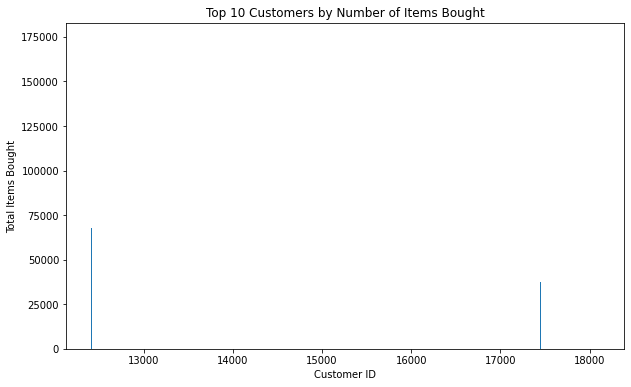

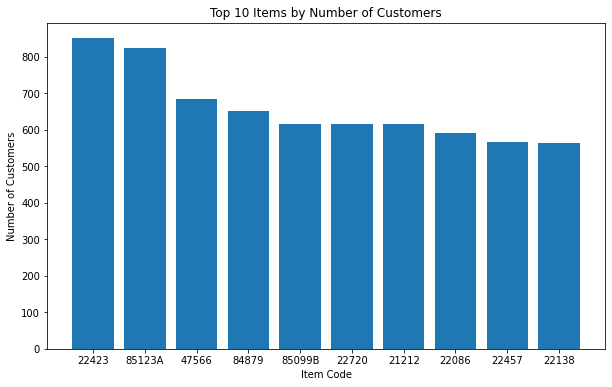

In [38]:
# group the data by CustomerID and sum the Quantity to get the total number of items bought by each customer
customer_items = processed.groupby('CustomerID')['Quantity'].sum()

# sort the customers by the total number of items bought and take the top 10
top_customers = customer_items.sort_values(ascending=False).head(10)

# create a bar graph of the top 10 customers and their total number of items bought
plt.figure(figsize=(10,6))
plt.bar(x=top_customers.index, height=top_customers.values)

# set the title and axis labels
plt.title('Top 10 Customers by Number of Items Bought')
plt.xlabel('Customer ID')
plt.ylabel('Total Items Bought')

# display the plot
plt.show()

# group the data by StockCode and count the number of unique CustomerIDs to get the number of customers who bought each item
item_customers = processed.groupby('StockCode')['CustomerID'].nunique()

# sort the items by the number of customers who bought them and take the top 10
top_items = item_customers.sort_values(ascending=False).head(10)

# create a bar graph of the top 10 items and the number of customers who bought them
plt.figure(figsize=(10,6))
plt.bar(x=top_items.index, height=top_items.values)

# set the title and axis labels
plt.title('Top 10 Items by Number of Customers')
plt.xlabel('Item Code')
plt.ylabel('Number of Customers')

# display the plot
plt.show()

## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [39]:
# YOUR CODE HERE
def add_total_price_column(df):
    # create a new column called TotalPrice that represents the total amount spent by each customer
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

    # return the updated DataFrame
    return df

In [ ]:
processed = add_total_price_column(processed)
processed.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,17.00,11,1
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,10.08,5,6
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,2.52,11,0
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,15.60,11,2
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,18.00,3,3


In [40]:
def create_customer_spending(df):
    # create a new DataFrame with each unique customer and their total spending
    customer_spending = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()

    # return the new DataFrame
    return customer_spending

In [43]:
#Customer ID checking...
# count of unique customer
processed.CustomerID.nunique()

4311

We will now create a new Dataframe which will have each unique customer will total amount they have spent.In this way we can cluster them according to Amount spent.

In [44]:
customer_spending = create_customer_spending(processed)
customer_spending.head()

,CustomerID,TotalPrice
0,12347.0,4091.80
1,12348.0,1395.48
2,12349.0,1241.26
3,12350.0,294.40
4,12352.0,1385.74


In [ ]:
customer_spending.shape

(4311, 2)

We can also find out how many times a Customer has visited the store by the column Invoice.


In [45]:
def calculate_customer_visits(processed):
    # group the data by CustomerID and count of each invoices for  for each customer
    customer_visits = processed.groupby('CustomerID')['InvoiceNo'].count().reset_index()

    # merge the customer_visits DataFrame with the customer_spending DataFrame
    customer_details = pd.merge(customer_spending, customer_visits, on='CustomerID')

    # return the customer_details DataFrame
    return customer_details

In [46]:
customer_details = calculate_customer_visits(processed)
customer_details.head()

,CustomerID,TotalPrice,InvoiceNo
0,12347.0,4091.80,171
1,12348.0,1395.48,26
2,12349.0,1241.26,65
3,12350.0,294.40,16
4,12352.0,1385.74,77


Here comes the interesting part:

We can also further get more details like which customers have not visited store for a long time and which have.By this we can cluster Customers which have not visited and see the underlying pattern.

This all can be done by the column ‘InvoiceDate’ which contains the datetime with respect to each invoice.

First we need to make sure that the columns is in datetime format ,if not we need to convert it to datetime format.

In [ ]:
data.InvoiceDate.dtypes

dtype('O')

Now as we need the exact no of days a customer has been last active we will use the InvoiceDate column to find out the most recent date from the InvoiceDate column and then subtract the Maximum date with the Invoice date for each customer which will give us no. of days the customer was last active.

In [47]:
def compute_recency(df):
    # Convert 'InvoiceDate' to datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    
    # Compute max_date
    max_date = max(df['InvoiceDate'])
    
    # Compute recency as the number of days between the 'InvoiceDate' and 'max_date'
    df['recency'] = (max_date - df['InvoiceDate']).dt.days
    
    return df

In [48]:
processed=compute_recency(processed)
processed.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,DayOfWeek,recency
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,17.00,11,1,9
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,10.08,5,6,201
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,2.52,11,0,17
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,15.60,11,2,9
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,18.00,3,3,259


Now we can groupby each customer and take out the .min() from the recency column to get the days when the customer was last seen.

In [49]:
last_seen = processed.groupby('CustomerID')['recency'].min()
last_seen = last_seen.reset_index()
last_seen

,CustomerID,recency
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35
...,...,...
4306,18280.0,277
4307,18281.0,180
4308,18282.0,7
4309,18283.0,3


Let's merge the customer_details DataFrame with the dates DataFrame on the CustomerID column

In [50]:
customer_details = pd.merge(customer_details, last_seen, on='CustomerID')
customer_details 

,CustomerID,TotalPrice,InvoiceNo,recency
0,12347.0,4091.80,171,1
1,12348.0,1395.48,26,74
2,12349.0,1241.26,65,18
3,12350.0,294.40,16,309
4,12352.0,1385.74,77,35
...,...,...,...,...
4306,18280.0,180.60,10,277
4307,18281.0,46.92,5,180
4308,18282.0,164.55,11,7
4309,18283.0,1923.03,676,3


Now the ‘TotalPrice’ column has lots of outliers which we need to remove in order to form good clusters.

In [51]:
def remove_outliers(customer_details):
    """
    Removes outliers from the TotalPrice column of customer_details DataFrame using the IQR method.

    Parameters:
    customer_details (pd.DataFrame): DataFrame containing customer details.

    Returns:
    pd.DataFrame: DataFrame with outliers removed.
    """

    z = customer_details.TotalPrice.quantile(0.05)
    y = customer_details.TotalPrice.quantile(0.95)
    iqr = y - z
    customer_details = customer_details[(customer_details['TotalPrice']>=z-1.5*iqr) & (customer_details['TotalPrice']<=y+1.5*iqr)]

    return customer_details

In [52]:
customer_details=remove_outliers(customer_details)
customer_details.head()

,CustomerID,TotalPrice,InvoiceNo,recency
0,12347.0,4091.80,171,1
1,12348.0,1395.48,26,74
2,12349.0,1241.26,65,18
3,12350.0,294.40,16,309
4,12352.0,1385.74,77,35


### Scale the data
 
Apply `StandardScaler` on the features.

In [53]:
def scale_data(df):
    """
    Scale the InvoiceNo, TotalPrice, and recency columns of the given DataFrame using StandardScaler.
    
    Parameters:
    data (pd.DataFrame): The input DataFrame containing the columns to be scaled.
    
    Returns:
    pd.DataFrame: The scaled DataFrame.
    """
    # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Scale the columns of interest
    scaled_values = scaler.fit_transform(df[['InvoiceNo', 'TotalPrice', 'recency']])
    
    # Create a new DataFrame with the scaled values
    scaled_data = pd.DataFrame(scaled_values, columns=['InvoiceNo', 'TotalPrice', 'recency'])
    
    return scaled_data

In [54]:
scaled_data=scale_data(customer_details)
scaled_data.head()

,InvoiceNo,TotalPrice,recency
0,0.821007,1.697867,-0.914512
1,-0.430443,0.101384,-0.185537
2,-0.093846,0.010070,-0.744751
3,-0.516750,-0.550563,2.161163
4,0.009722,0.095617,-0.574989


## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [ ]:
# YOUR CODE HERE to apply KMeans
#The max_iter parameter specifies the maximum number of iterations the algorithm can perform in order to converge.
#The verbose parameter is set to True, which means that progress messages will be printed during the algorithm's execution.
#Inertia_scores = []
#for i in range(2,7):
  #kmeans = KMeans(n_clusters=i,max_iter=40,verbose=True).fit(scaled_values)
  #kmeans = KMeans(n_clusters=i,max_iter=40,n_init=10).fit(scaled_values)# add 'verbose=True' if you want to print progress report of the algorithm
  #Inertia_scores.append(kmeans.inertia_)#appendthe sum of squared distances of samples to their closest cluster center. This is a measure of the quality of the clustering solution.
#print('Inertia_scores: ',Inertia_scores)

In [55]:
kmeans = KMeans(n_clusters=3,max_iter=40,n_init=10).fit(scaled_data)

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

Inertia_scores:  [7969.467093065738, 4722.662413579534, 3670.0844994782947, 2982.298684940287, 2567.8235645992418]


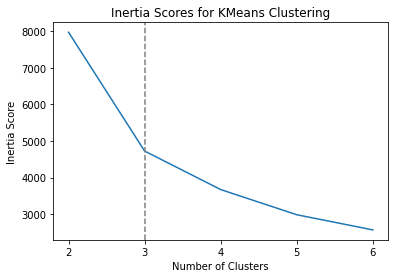

In [56]:
Inertia_scores = []
for i in range(2,7):
  kmeans = KMeans(n_clusters=i,max_iter=40,n_init=10).fit(scaled_data)# add 'verbose=True' if you want to print progress report of the algorithm
  Inertia_scores.append(kmeans.inertia_)#appendthe sum of squared distances of samples to their closest cluster center. This is a measure of the quality of the clustering solution.

print('Inertia_scores: ',Inertia_scores)
plt.plot(range(2,7,1),Inertia_scores)
plt.xticks(ticks=range(2,7))
plt.title('Inertia Scores for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.axvline(x=3, color='grey', linestyle='--') # Add a dashed line for "ideal" number of clusters
plt.show()

Silhouette_scores:  [0.574375891909071, 0.5221967290299858, 0.5046547083751657, 0.49659943792085814, 0.43301903500375294]


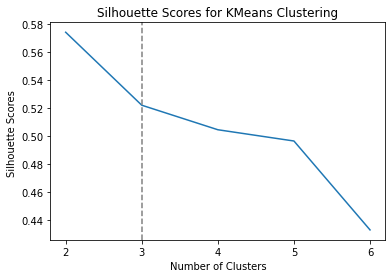

In [57]:
# Calculate silhouette scores
from sklearn.metrics import silhouette_score
Silhouette_scores = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, max_iter=40,n_init=10).fit(scaled_data)
    Silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
print('Silhouette_scores: ',Silhouette_scores)
plt.plot(range(2,7,1),Silhouette_scores)
plt.xticks(ticks=range(2,7))
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores ')
plt.axvline(x=3, color='grey', linestyle='--') # Add a dashed line for "ideal" number of clusters
plt.show()

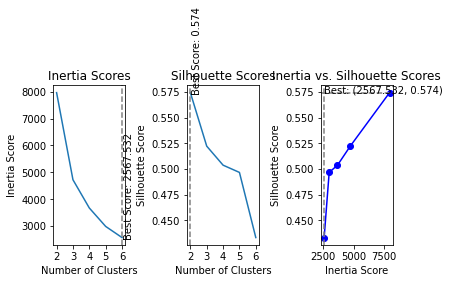

In [58]:
# Calculate inertia scores
inertia_scores = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, max_iter=40,n_init=10).fit(scaled_data)
    inertia_scores.append(kmeans.inertia_)

# Calculate silhouette scores
silhouette_scores = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, max_iter=40, n_init=10).fit(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Find best inertia score and corresponding number of clusters
best_inertia = min(inertia_scores)
best_inertia_index = inertia_scores.index(best_inertia) + 2  # Adjust for starting cluster size

# Find best silhouette score and corresponding number of clusters
best_silhouette = max(silhouette_scores)
best_silhouette_index = silhouette_scores.index(best_silhouette) + 2  # Adjust for starting cluster size

# Plot inertia scores
plt.subplot(1, 3, 1)
plt.plot(range(2, 7), inertia_scores)
plt.xticks(range(2, 7))
plt.title('Inertia Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.axvline(x=best_inertia_index, color='grey', linestyle='--')
plt.text(best_inertia_index + 0.1, best_inertia, f'Best Score: {best_inertia:.3f}', rotation=90)

# Plot silhouette scores
plt.subplot(1, 3, 2)
plt.plot(range(2, 7), silhouette_scores)
plt.xticks(range(2, 7))
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.axvline(x=best_silhouette_index, color='grey', linestyle='--')
plt.text(best_silhouette_index + 0.1, best_silhouette, f'Best Score: {best_silhouette:.3f}', rotation=90)

# Plot joint graph
plt.subplot(1, 3, 3)
plt.plot(inertia_scores, silhouette_scores, 'bo-')
plt.title('Inertia vs. Silhouette Scores')
plt.xlabel('Inertia Score')
plt.ylabel('Silhouette Score')
plt.axvline(x=best_inertia, color='grey', linestyle='--')
plt.axhline(y=best_silhouette, color='grey', linestyle='--')
plt.text(best_inertia + 0.1, best_silhouette, f'Best: ({best_inertia:.3f}, {best_silhouette:.3f})')

plt.tight_layout()
plt.show()

From the above elbow graphs and silhouette scores we can take ‘3’ as our k value for number of clusters.

Lets create our final Model:

In [59]:
kmeans = KMeans(n_clusters=3,max_iter=50,n_init=10).fit(scaled_data)
clusters = kmeans.labels_
customer_details['Cluster']=clusters
customer_details

<ipython-input-59-16c28b0d98f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_details['Cluster']=clusters


,CustomerID,TotalPrice,InvoiceNo,recency,Cluster
0,12347.0,4091.80,171,1,0
1,12348.0,1395.48,26,74,1
2,12349.0,1241.26,65,18,1
3,12350.0,294.40,16,309,2
4,12352.0,1385.74,77,35,1
...,...,...,...,...,...
4306,18280.0,180.60,10,277,2
4307,18281.0,46.92,5,180,2
4308,18282.0,164.55,11,7,1
4309,18283.0,1923.03,676,3,0


In [60]:
customer_details

,CustomerID,TotalPrice,InvoiceNo,recency,Cluster
0,12347.0,4091.80,171,1,0
1,12348.0,1395.48,26,74,1
2,12349.0,1241.26,65,18,1
3,12350.0,294.40,16,309,2
4,12352.0,1385.74,77,35,1
...,...,...,...,...,...
4306,18280.0,180.60,10,277,2
4307,18281.0,46.92,5,180,2
4308,18282.0,164.55,11,7,1
4309,18283.0,1923.03,676,3,0


Here we have created our final model with 3 clusters and added our cluster labels obtained from ‘kmeans.labels_’ to our Dataframe consisting of Unique customers.

With the help of boxplots we can visualize the clusters formed on different features:

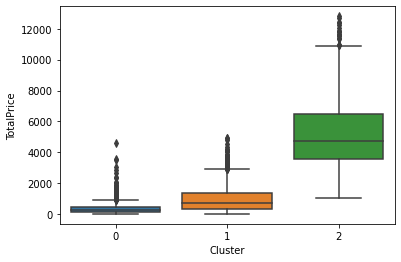

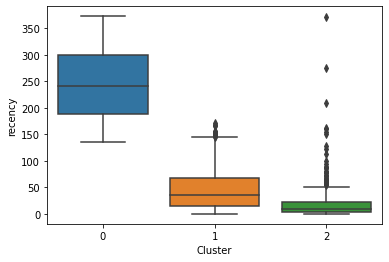

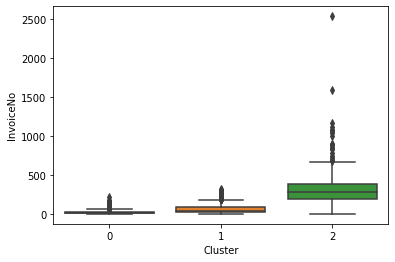

In [ ]:
sns.boxplot(x='Cluster',y='TotalPrice',data=customer_details)
plt.show()
sns.boxplot(x='Cluster',y='recency',data=customer_details)
plt.show()
sns.boxplot(x='Cluster',y='InvoiceNo',data=customer_details)
plt.show()

### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [64]:
# YOUR CODE HERE
# apply DBSCAN clustering algorithm
dbscan = DBSCAN(eps=0.53, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)

# get the number of clusters formed by DBSCAN
dbscan_num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print("Number of clusters formed by DBSCAN:", dbscan_num_clusters)

# apply KMeans clustering algorithm
kmeans = KMeans( n_clusters=3,max_iter=50,n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_data)

# get the number of clusters formed by KMeans
kmeans_num_clusters = len(set(kmeans_labels))
print("Number of clusters formed by KMeans:", kmeans_num_clusters)

# compare the results of DBSCAN and KMeans clustering
print("DBSCAN labels:", dbscan_labels)
print("KMeans labels:", kmeans_labels)


Number of clusters formed by DBSCAN: 3
Number of clusters formed by KMeans: 3
DBSCAN labels: [ 0  0  0 ...  0 -1  0]
KMeans labels: [2 0 0 ... 0 2 0]


### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

In [65]:
scaled_data.head(3)

,InvoiceNo,TotalPrice,recency
0,0.821007,1.697867,-0.914512
1,-0.430443,0.101384,-0.185537
2,-0.093846,0.010070,-0.744751


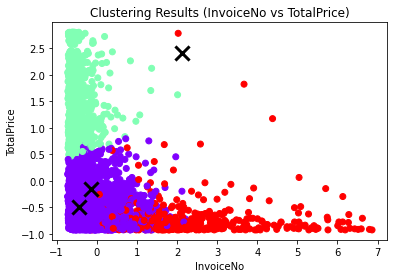

In [82]:
# extract cluster centers from KMeans and DBSCAN
kmeans_centers = kmeans.cluster_centers_[:, :2]
#dbscan_centers = dbscan.components_[:, :2]

# create scatter plot of InvoiceNo vs TotalPrice, color-coded by cluster labels
plt.scatter(scaled_data.iloc[:, 1], scaled_data.iloc[:, 2], c=kmeans_labels, cmap='rainbow')
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], marker='x', s=200, linewidths=3, color='black')
#plt.scatter(dbscan_centers[:, 0], dbscan_centers[:, 1], marker='s', s=100, linewidths=2, color='white')
plt.title('Clustering Results (InvoiceNo vs TotalPrice)')
plt.xlabel('InvoiceNo')
plt.ylabel('TotalPrice')
plt.show()

In [75]:
kmeans_centers[:,1]

array([-0.15299306, -0.49571948,  2.40871934])

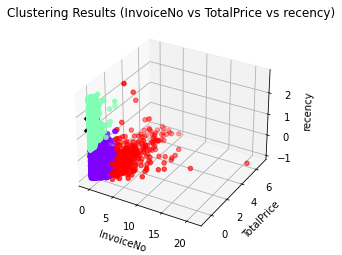

In [86]:
# extract cluster centers from KMeans and DBSCAN
kmeans_centers = kmeans.cluster_centers_
dbscan_centers = dbscan.components_

# create 3D scatter plot of InvoiceNo vs TotalPrice vs recency, color-coded by cluster labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaled_data.iloc[:, 0], scaled_data.iloc[:, 1], scaled_data.iloc[:, 2], c=kmeans_labels, cmap='rainbow')
ax.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], kmeans_centers[:, 2], marker='x', s=200, linewidths=3, color='black')
#ax.scatter(dbscan_centers[:, 0], dbscan_centers[:, 1], dbscan_centers[:, 2], marker='s', s=100, linewidths=2, color='white')
ax.set_title('Clustering Results (InvoiceNo vs TotalPrice vs recency)')
ax.set_xlabel('InvoiceNo')
ax.set_ylabel('TotalPrice')
ax.set_zlabel('recency')
plt.show()

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [ ]:
# YOUR CODE HERE
clustered_data = scaled_data.copy()
clustered_data['Cluster'] = kmeans_labels

In [ ]:
train_data, val_data = train_test_split(clustered_data, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# separate the feature and target variables
X_train = train_data[['TotalPrice', 'recency']]
y_train = train_data['Cluster']

# train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# predict the cluster labels for validation data
X_val = val_data[['TotalPrice', 'recency']]
y_val_true = val_data['Cluster']
y_val_pred = clf.predict(X_val)

In [ ]:
#Finally, we can find the accuracy of the model using the validation data:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val_true, y_val_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9400705052878966


### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [87]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom


In [ ]:
test.shape

(27096, 8)

In [ ]:
# Call the remove_duplicates function
non_duplicates = remove_duplicates(test)

# Print the original and non-duplicated DataFrames
print('Original DataFrame:\n', test.shape)
print('Non-duplicated DataFrame:\n', non_duplicates.shape)

Original DataFrame:
 (27096, 8)
Non-duplicated DataFrame:
 (27082, 8)


In [ ]:
# Call the drop_nulls function
non_nulls = drop_nulls(non_duplicates)

# Print the original and non-null DataFrames
print('Original DataFrame:\n', non_duplicates.shape)
print('Non-null DataFrame:\n', non_nulls.shape)

Null counts:
 CustomerID     6817
Description      69
InvoiceNo         0
StockCode         0
Quantity          0
InvoiceDate       0
UnitPrice         0
Country           0
dtype: int64
Original DataFrame:
 (27082, 8)
Non-null DataFrame:
 (20265, 8)


In [ ]:
# Call the drop_cancelled_orders function
non_cancelled = drop_cancelled_orders(non_nulls)

# Print the original and non-cancelled DataFrames
print('Original DataFrame:\n', non_nulls.shape)
print('Non-cancelled DataFrame:\n', non_cancelled.shape)

Number of cancelled orders: 471
Original DataFrame:
 (20265, 8)
Non-cancelled DataFrame:
 (19794, 8)


In [ ]:
# Define the irrelevant codes
irrelevant_codes = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']

# Call the filter_irrelevant_transactions function
filtered = filter_irrelevant_transactions(non_cancelled, irrelevant_codes)

# Print the original and filtered DataFrames
print('Original DataFrame:\n', non_cancelled.shape)
print('Filtered DataFrame:\n', filtered.shape)

There are 84 irrelevant codes in the data.
Original DataFrame:
 (19794, 8)
Filtered DataFrame:
 (19710, 8)


In [ ]:
# Call the handle_outliers function
processed = handle_outliers(filtered)

# Print the original and processed DataFrames
print('Original DataFrame:\n', filtered.shape)
print('Processed DataFrame:\n', processed.shape)

Identified 337 outliers. DataFrame shape after outlier removal: (19373, 8)
Original DataFrame:
 (19710, 8)
Processed DataFrame:
 (19373, 8)


In [ ]:
data = convert_date_column(processed, 'InvoiceDate')
data

Before:  object
After:  datetime64[ns]
The minimum date is: 2010-12-01 08:26:00
The maximum date is: 2011-12-09 12:50:00


<ipython-input-30-3a277c132227>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_datetime(df[column_name])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom
...,...,...,...,...,...,...,...,...
27087,549902,23206,LUNCH BAG APPLE DESIGN,10,2011-04-12 16:17:00,1.65,14006.0,United Kingdom
27089,552322,21181,PLEASE ONE PERSON METAL SIGN,12,2011-05-09 09:16:00,2.10,17049.0,United Kingdom
27090,568376,23347,I LOVE LONDON BEAKER,24,2011-09-26 17:20:00,1.25,14031.0,United Kingdom
27094,579623,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2011-11-30 12:15:00,0.55,16062.0,United Kingdom


In [ ]:
data = add_total_price_column(data)
data.head()

<ipython-input-40-6207cf9b365a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,20.40
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,27.80
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,2.60
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,5.85
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,19.90


In [ ]:
customer_spending = create_customer_spending(data)
customer_spending.head()

,CustomerID,TotalPrice
0,12347.0,218.20
1,12349.0,112.54
2,12353.0,59.70
3,12354.0,24.40
4,12355.0,165.30


In [ ]:
customer_details = calculate_customer_visits(data)
customer_details

,CustomerID,TotalPrice,InvoiceNo
0,12347.0,218.20,11
1,12349.0,112.54,5
2,12353.0,59.70,2
3,12354.0,24.40,2
4,12355.0,165.30,3
...,...,...,...
3273,18272.0,173.50,10
3274,18276.0,23.40,1
3275,18282.0,13.50,1
3276,18283.0,109.26,46


In [ ]:
processed=compute_recency(processed)
processed.head()

<ipython-input-49-905b97a360a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
<ipython-input-49-905b97a360a9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recency'] = (max_date - df['InvoiceDate']).dt.days


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,recency
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,20.40,191
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,27.80,195
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,2.60,231
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,5.85,23
4,546157,22180,RETROSPOT LAMP,2,2011-03-10 08:40:00,9.95,13502.0,United Kingdom,19.90,274


In [ ]:
#Now we can groupby each customer and take out the .min() from the recency column to get the days when the customer was last seen.
last_seen = processed.groupby('CustomerID')['recency'].min()
last_seen = last_seen.reset_index()
last_seen


,CustomerID,recency
0,12347.0,1
1,12349.0,18
2,12353.0,203
3,12354.0,231
4,12355.0,213
...,...,...
3273,18272.0,2
3274,18276.0,43
3275,18282.0,125
3276,18283.0,3


Let's merge the customer_details DataFrame with the dates DataFrame on the CustomerID column

In [ ]:
customer_details = pd.merge(customer_details, last_seen, on='CustomerID')
customer_details 

,CustomerID,TotalPrice,InvoiceNo,recency
0,12347.0,218.20,11,1
1,12349.0,112.54,5,18
2,12353.0,59.70,2,203
3,12354.0,24.40,2,231
4,12355.0,165.30,3,213
...,...,...,...,...
3273,18272.0,173.50,10,2
3274,18276.0,23.40,1,43
3275,18282.0,13.50,1,125
3276,18283.0,109.26,46,3


Now the ‘TotalPrice’ column has lots of outliers which we need to remove in order to form good clusters.

In [ ]:
customer_details=remove_outliers(customer_details)
customer_details.head()

,CustomerID,TotalPrice,InvoiceNo,recency
0,12347.0,218.20,11,1
1,12349.0,112.54,5,18
2,12353.0,59.70,2,203
3,12354.0,24.40,2,231
4,12355.0,165.30,3,213


In [ ]:
scaled_data=scale_data(customer_details)
scaled_data.head()

,InvoiceNo,TotalPrice,recency
0,0.825708,1.285156,-0.992440
1,-0.044637,0.281257,-0.824567
2,-0.479809,-0.220787,1.002284
3,-0.479809,-0.556180,1.278780
4,-0.334751,0.782542,1.101033


The trained model to predict the labels for the Test data set:

In [ ]:
# Make predictions using the trained model
predictions = kmeans.predict(scaled_data)

# Print the predicted clusters
print(predictions)

[0 1 2 ... 1 0 1]


Prediction it with trained supervised ML model

In [ ]:
clustered_data = scaled_data.copy()
clustered_data['Cluster'] = predictions

In [ ]:
# predict the cluster labels for validation data
X_val = clustered_data[['TotalPrice', 'recency']]
y_val_true = clustered_data['Cluster']
y_val_pred = clf.predict(X_val)

In [ ]:
#Finally, we can find the accuracy of the model using the validation data:
accuracy = accuracy_score(y_val_true, y_val_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9342592592592592


### Report Analysis


1.   Discuss the pros and cons of removing the missing values vs replacing with the mean values.
1.   Based on the visualization of clusters, comment on the difference in buying patterns of each cluster.

2.   What other methods could be used to determine the optimal no. of clusters?



QUEST_1- Discuss the pros and cons of removing the missing values vs replacing with the mean values

> Ans_01:


> Removing the missing values:


**Pros:**

Can avoid bias in the data by not replacing missing values with arbitrary values.
Can improve the quality of the data by removing incomplete observations.

**Cons:**

Can lead to loss of data, especially if a large proportion of the data is missing.
Can reduce the representativeness of the data by removing incomplete observations that may have been representative of a particular group.



> **Replacing missing values with mean values:**

**Pros:**

Can be a simple and effective way to impute missing data.
Can preserve the sample size by not removing incomplete observations.

**Cons:**

Can lead to bias in the data if the mean values are not representative of the missing values.
Can reduce the variability of the data by replacing missing values with a single value.
In general, the choice of whether to remove missing values or replace them with mean values depends on the specific dataset and the analysis objectives. If the missing values are a small proportion of the data and the dataset is large enough, removing them may be a reasonable option. If the missing values are a large proportion of the data or the dataset is small, replacing them with mean values may be a better option.



QUEST_2- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster

> Ans02:

Based on the visualization of clusters, we can observe the following differences in buying patterns of each cluster:

0.   Cluster 0: This cluster consists of customers with low total spending and low recency. These customers are less engaged with the store and may need incentives to continue purchasing.
1.   Cluster 1: This cluster consists of customers with medium total spending and medium recency. These customers are moderately engaged with the store and may be receptive to promotions and offers.
2.  Cluster 2: This cluster consists of customers with high total spending and high recency. These customers are highly engaged with the store and may be the most valuable customers.

QUEST_3- What other methods could be used to determine the optimal no. of clusters?

> Ans03:

To determine the optimal number of clusters, we can use various methods, such as:





1.   Elbow method: This method involves plotting the sum of squared distances of each point to its cluster centroid for different numbers of clusters and selecting the number of clusters where the curve starts to flatten out (the "elbow point").


2.   Silhouette method: This method involves calculating the mean silhouette coefficient for different numbers of clusters, where a higher silhouette coefficient indicates better clustering performance. The number of clusters with the highest mean silhouette coefficient is selected as the optimal number of clusters.

3.   Gap statistic method: This method involves comparing the within-cluster dispersion of the data to a null reference distribution, and selecting the number of clusters where the gap between the observed and expected within-cluster dispersion is the largest.

4.   There are also other methods such as the Calinski-Harabasz index and the Davies-Bouldin index that can be used to determine the optimal number of clusters. The choice of method depends on the characteristics of the data and the analysis objectives.
